In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

# Load data

In [2]:
data = pd.read_csv('../winequality.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


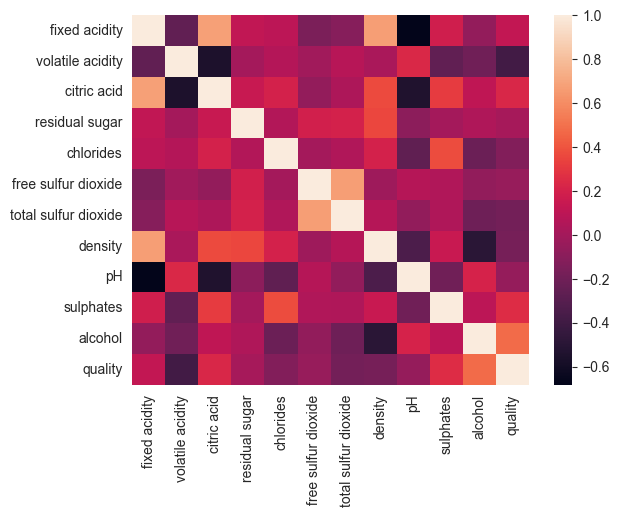

In [3]:
import seaborn as sns

sns.heatmap(data.corr());

# Linear Regression Diagnostics

In [4]:
import statsmodels.api as sm

X = data.drop('quality', axis=1)
y = data['quality']

# Fit regression model (using the natural log of one of the regressors)
lm1 = sm.OLS(y, X)
results_lm1 = lm1.fit()

In [5]:
# Inspect the results
results_lm1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.987    
Dependent Variable:     quality          AIC:                         3161.3583
Date:                   2023-02-13 14:47 BIC:                         3220.5068
No. Observations:       1599             Log-Likelihood:              -1569.7  
Df Model:               11               F-statistic:                 1.108e+04
Df Residuals:           1588             Prob (F-statistic):          0.00     
R-squared (uncentered): 0.987            Scale:                       0.41994  
---------------------------------------------------------------------------------
                         Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
---------------------------------------------------------------------------------
fixed acidity            0.0042     0.0165    0.2549   0.7988   -0.0281    0.0365
volatile acidity        -1.0997     0.1201   -9.1571   0.0000   -1.3353   -0.8642
citric acid             -0.1841     0.1472   -1.2512   0.2110   -0.4728    0.1045
residual sugar           0.0071     0.0121    0.5868   0.5574   -0.0166    0.0307
chlorides               -1.9114     0.4178   -4.5755   0.0000   -2.7308   -1.0920
free sulfur dioxide      0.0045     0.0022    2.1017   0.0357    0.0003    0.0088
total sulfur dioxide    -0.0033     0.0007   -4.5655   0.0000   -0.0047   -0.0019
density                  4.5291     0.6253    7.2428   0.0000    3.3026    5.7557
pH                      -0.5229     0.1600   -3.2682   0.0011   -0.8367   -0.2091
sulphates                0.8871     0.1108    8.0061   0.0000    0.6697    1.1044
alcohol                  0.2970     0.0173   17.2175   0.0000    0.2632    0.3309
-------------------------------------------------------------------------------
Omnibus:                  25.388            Durbin-Watson:               1.754 
Prob(Omnibus):            0.000             Jarque-Bera (JB):            37.530
Skew:                     -0.159            Prob(JB):                    0.000 
Kurtosis:                 3.680             Condition No.:               2467  
===============================================================================
* The condition number is large (2e+03). This might indicate             strong
multicollinearity or other numerical problems.
"""

In [70]:
import statsmodels.stats.api as sms

test = sms.jarque_bera(results_lm1.resid)
test

(37.529521118035085,
 7.08872347098949e-09,
 -0.15867634403395264,
 3.680133918757287)

In [23]:
results_lm1.rsquared

0.987134666232821

In [26]:
np.linalg.cond(results_lm1.model.exog)

2467.362925286345

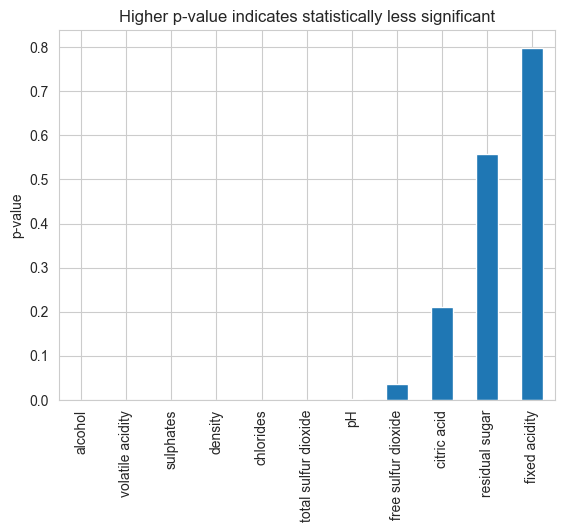

In [32]:
results_lm1.pvalues.sort_values().plot.bar(title='Higher p-value indicates statistically less significant', ylabel='p-value');

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

to_analyze = X
to_analyze = to_analyze.assign(const=1)

vif_df = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
})

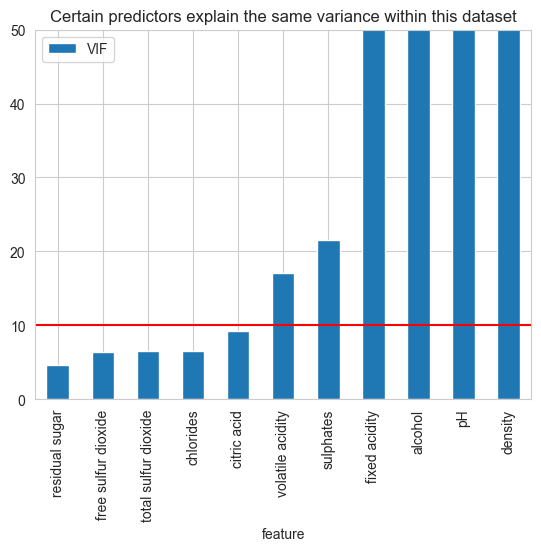

In [37]:
ax = vif_df.sort_values('VIF').set_index('feature').plot.bar(title='Certain predictors explain the same variance within this dataset', ylim=(0, 50))

ax.axhline(y=10, color='r', linestyle='-');

The high p-value is caused by the presence of multi collinearity. We can apply RandomForest in order to find the most contributed predictors.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

Split train and test data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
X_train.shape, X_test.shape

((1199, 11), (400, 11))

Train RFC to obtain feature importance

In [49]:
# We use min_samples_leaf=20 to overcome overfitting
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, min_samples_leaf=20)
rf_model.fit(X_train, y_train)

print("Accuracy on train data: {:.2f}".format(rf_model.score(X_train, y_train)))
print("Accuracy on test data: {:.2f}".format(rf_model.score(X_test, y_test)))

Accuracy on train data: 0.68
Accuracy on test data: 0.58


Plot feature importance

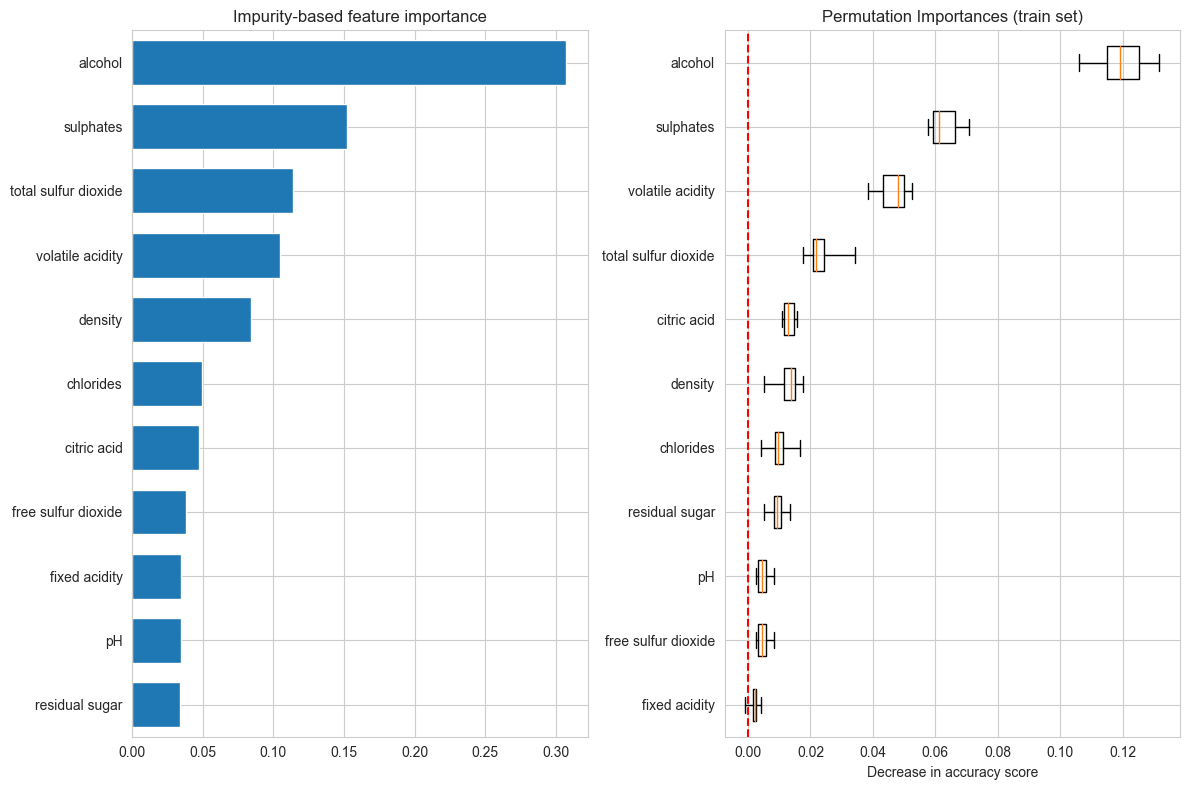

In [50]:
import matplotlib.pyplot as plt

result = permutation_importance(rf_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(rf_model.feature_importances_)
tree_indices = np.arange(0, len(rf_model.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, rf_model.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_title('Impurity-based feature importance')
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(X.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(rf_model.feature_importances_)))

ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    whis=10,
    labels=X.columns[perm_sorted_idx],
)
ax2.set_title('Permutation Importances (train set)')
ax2.set_xlabel('Decrease in accuracy score')
ax2.axvline(x=0, color="red", linestyle="--")
fig.tight_layout()
plt.show()

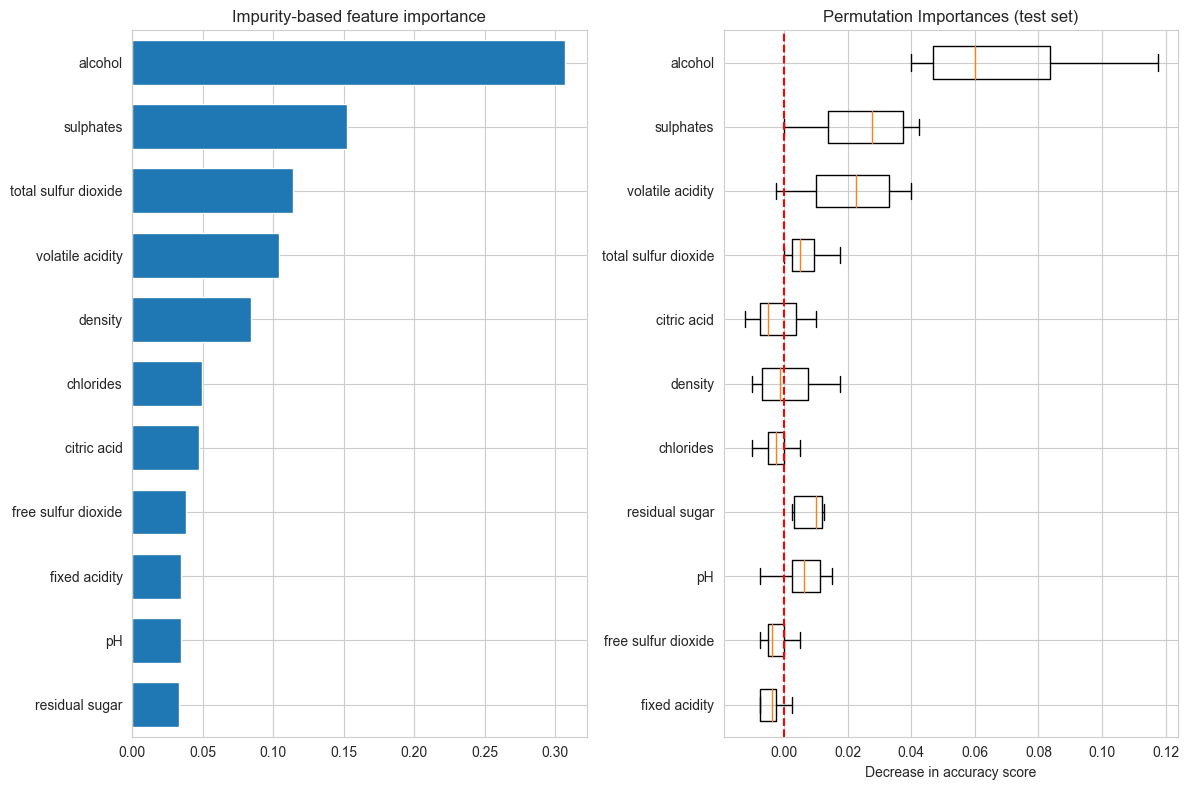

In [51]:
result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_sorted_idx = perm_sorted_idx

tree_importance_sorted_idx = tree_importance_sorted_idx
tree_indices = np.arange(0, len(rf_model.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, rf_model.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_title('Impurity-based feature importance')
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(X.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(rf_model.feature_importances_)))

ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    whis=10,
    labels=X.columns[perm_sorted_idx],
)
ax2.set_title('Permutation Importances (test set)')
ax2.set_xlabel('Decrease in accuracy score')
ax2.axvline(x=0, color="red", linestyle="--")
fig.tight_layout()
plt.show()

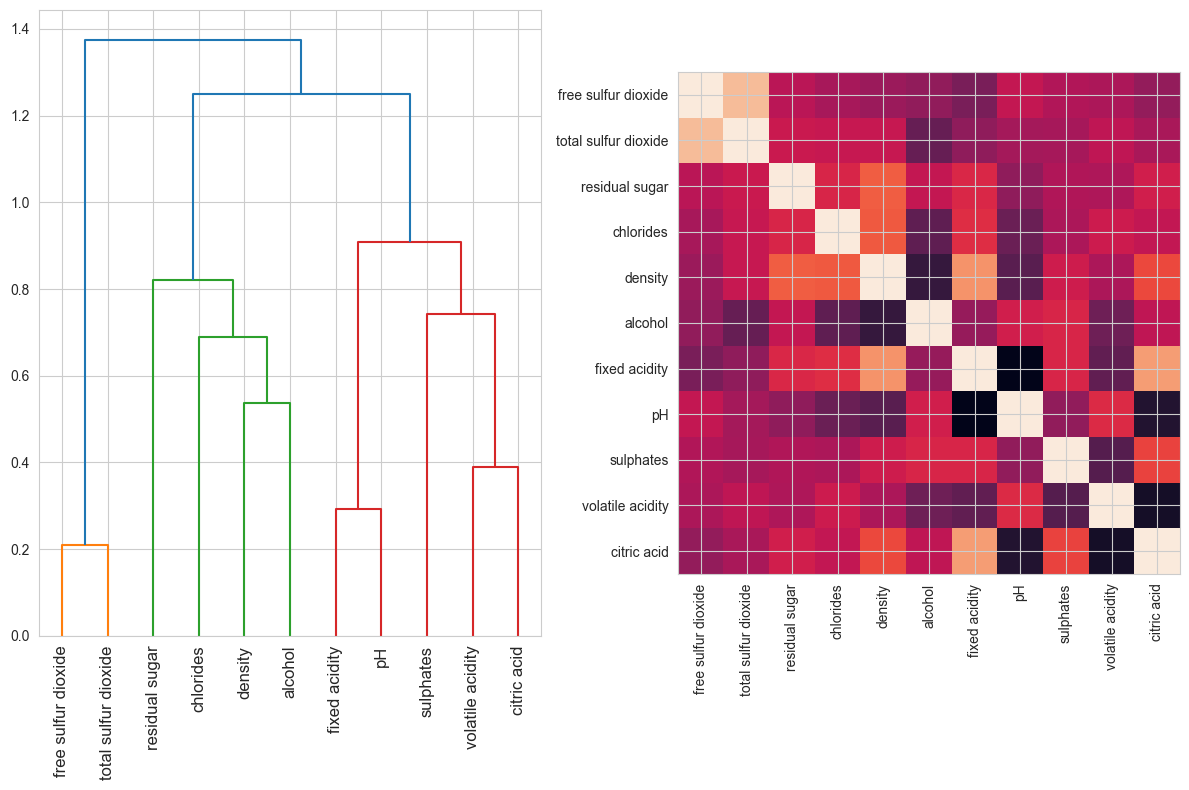

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage,
    labels=X.columns,
    ax=ax1,
    leaf_rotation=90
)

dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

In [53]:
from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)

# Merge similar clusters to one cluster
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

# Select the first element of a cluster (cluster_id_to_feature_ids)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

# subset selected columns
X_train_sel = X_train.iloc[:, selected_features]
X_test_sel = X_test.iloc[:, selected_features]

In [54]:
X_train_sel.head()

,fixed acidity,residual sugar,free sulfur dioxide
582,11.7,2.2,5.0
626,8.8,2.2,5.0
1030,7.1,2.1,9.0
620,8.3,3.4,16.0
490,9.3,2.8,24.0


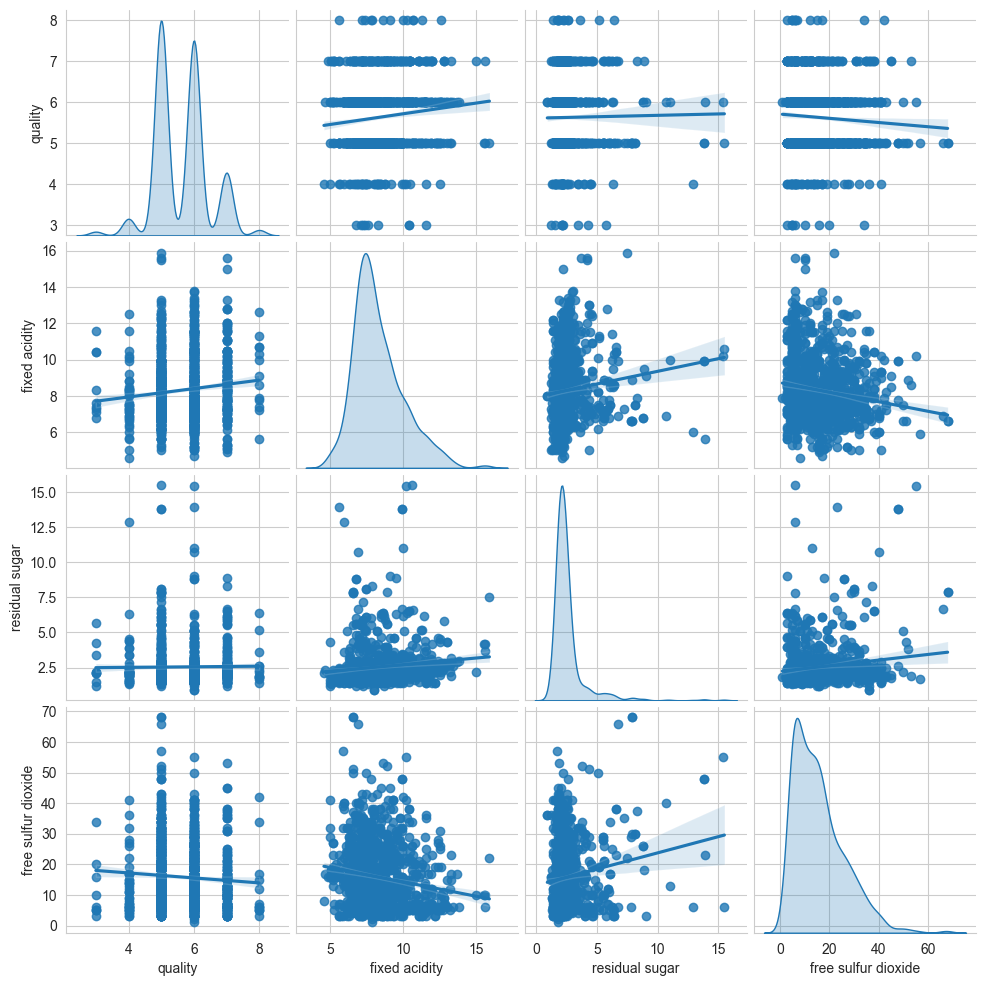

In [55]:
X_train_sel.insert(0, 'quality', data.quality)
_ = sns.pairplot(X_train_sel, kind="reg", diag_kind="kde")
X_train_sel = X_train_sel.drop('quality', axis=1)

In [27]:
def eval_metrics(actual, pred, score=None):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [91]:
lm2 = sm.OLS(y_train, X_train_sel)
results_lm2 = lm2.fit()

In [92]:
results_lm2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.952    
Dependent Variable:     quality          AIC:                         3939.4702
Date:                   2023-02-06 20:39 BIC:                         3954.7380
No. Observations:       1199             Log-Likelihood:              -1966.7  
Df Model:               3                F-statistic:                 7879.    
Df Residuals:           1196             Prob (F-statistic):          0.00     
R-squared (uncentered): 0.952            Scale:                       1.5609   
----------------------------------------------------------------------------------
                       Coef.     Std.Err.       t       P>|t|     [0.025    0.975]
----------------------------------------------------------------------------------
fixed acidity          0.5581      0.0095    58.9926    0.0000    0.5395    0.5767
residual sugar         0.1131      0.0258     4.3864    0.0000    0.0625    0.1636
free sulfur dioxide    0.0332      0.0033     9.9622    0.0000    0.0266    0.0397
-------------------------------------------------------------------------------
Omnibus:                  40.500            Durbin-Watson:               1.962 
Prob(Omnibus):            0.000             Jarque-Bera (JB):            56.407
Skew:                     -0.335            Prob(JB):                    0.000 
Kurtosis:                 3.825             Condition No.:               15    
===============================================================================

"""

In [100]:
from sklearn.metrics import mean_squared_error

prediction = results_lm2.predict(X_test_sel)
eval_metrics(y_test, prediction)

  Score: None
  RMSE: 1.2462961419107343
  MAE: 0.989277129902225
  R2: -1.5109436901707802


(1.2462961419107343, 0.989277129902225, -1.5109436901707802)

In [101]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(n_jobs=-1).fit(X_train_sel, y_train)
prediction = results_lm2.predict(X_test_sel)
score = model.score(X_test_sel, y_test)

eval_metrics(y_test, prediction, score)

  Score: 0.01895591459489665
  RMSE: 1.2462961419107343
  MAE: 0.989277129902225
  R2: -1.5109436901707802


(1.2462961419107343, 0.989277129902225, -1.5109436901707802)

## Model selection

Apply L2 regularization

In [9]:
all_models = {}

In [10]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, ElasticNetCV

In [11]:
model_l2 = Ridge(alpha=1.0).fit(X_train, y_train)
all_models['ridge'] = model_l2

Apply L2 regularization with CV

In [16]:
model_l2_cv = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)
all_models['ridge_cv'] = model_l2_cv

Apply ElasticNet L1/L2 regularization

In [13]:
model_elas = ElasticNet(alpha=.5, l1_ratio=.1, random_state=42).fit(X_train, y_train)
all_models['elasticnet'] = model_elas

Apply ElasticNet CV L1/L2 regularization

In [18]:
model_elas_cv = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, n_jobs=-1, random_state=42).fit(X_train, y_train)
all_models['elasticnet_cv'] = model_elas_cv

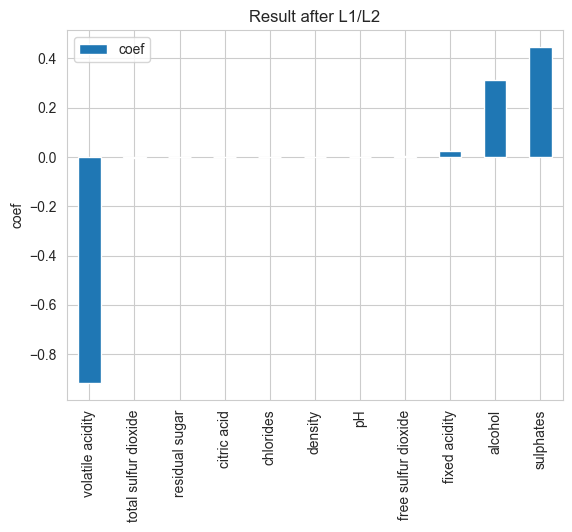

In [128]:
pd.DataFrame({
    'coef': model_elas_cv.coef_
}, index=model_elas_cv.feature_names_in_).sort_values(by="coef").plot.bar(title='Result after L1/L2', ylabel='coef');

In [19]:
all_models

{'ridge': Ridge(),
 'ridge_cv': RidgeCV(alphas=[0.001, 0.01, 0.1, 1]),
 'elasticnet': ElasticNet(alpha=0.5, l1_ratio=0.1, random_state=42),
 'elasticnet_cv': ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], n_jobs=-1,
              random_state=42)}

In [28]:
eval_models = {
    'acc': [],
    'rmse': [],
    'mae': [],
    'r2': []
}


for model_name in all_models:
    model = all_models[model_name]
    prediction = model.predict(X_test)
    score = model_elas_cv.score(X_test, y_test)
    rmse, mae, r2 = eval_metrics(y_test, prediction, score)

    eval_models['acc'].append(score)
    eval_models['rmse'].append(rmse)
    eval_models['mae'].append(mae)
    eval_models['r2'].append(r2)

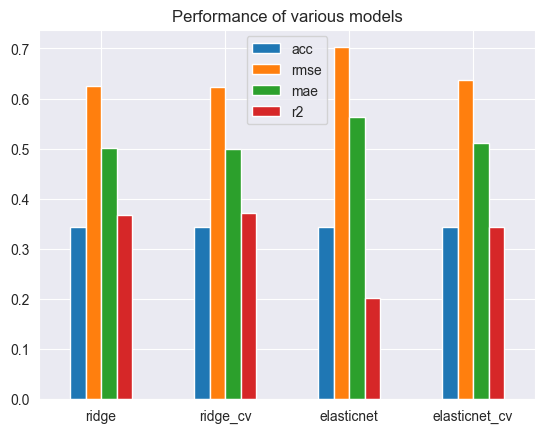

In [33]:
pd.DataFrame(
    eval_models, index=all_models.keys()
).plot.bar(title='Performance of various models', rot=0);